# Introduction

**The purpose of this anlaysis is trying to find out the products that are purchased most in the HappyDB dataset.**  
These products are more likely to make people feel happy.

**I'll use KOKO, a rule-based entity extraction system, to perform the analysis.**  

KOKO allows users to specify conditions of desirable entities with a declarative language (see [KOKO syntax](#koko_syntax)).  
Those entities that obtain scores higher than a threshold are extracted.

KOKO is especially suitable for entity extraction with limited evidence in the corpus (e.g. extraction of cafe names within only one or a few blogs). 

**The whole analysis described in this notebook comprises the following steps:**  

- Data preprocessing: load HappyDB dataset and convert it to a text file as input to KOKO.
- KOKO introduction: briefly introduce the syntax and semantics of KOKO, with an example query.
- Entity extraction: a KOKO query is written and evaluated, extracting product names in the dataset.

Let's get started!

We first import necessary packages:

In [33]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

# 1. Data preprocessing

First, let's load the data and take a look at the happy moments.  

## Load HappyDB

In [44]:
data = pd.read_csv('./cleaned_hm.csv')
data.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,category,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,affection,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,affection,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,exercise,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,bonding,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,affection,1,NaN,affection


Within the dataset, the most interesting part -- which is also the input to our analysis -- is the coloum of 'cleaned_hm'.  

'cleaned_hm' stands for "cleaned happy moments". Let's take a look.

Let's do a word count first

In [45]:
df_hm = data[data['cleaned_hm'].notnull()]
len_count = df_hm['cleaned_hm'].apply(lambda x: len(x.split()))
len_count.describe()

count    100738.000000
mean         18.265560
std          21.465023
min           1.000000
25%           9.000000
50%          14.000000
75%          21.000000
max        1179.000000
Name: cleaned_hm, dtype: float64

Let's show more detailed results.

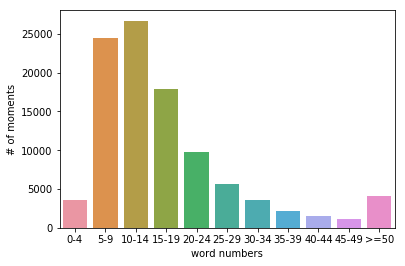

In [40]:
length_order = ["0-4", "5-9", "10-14", "15-19", "20-24", "25-29", "30-34", "35-39", \
                "40-44", "45-49", ">=50"]
length_category = len_count.apply(lambda x: length_order[min(10, int(x/5))])
length_counts = pd.DataFrame(length_category.value_counts()).reset_index()
length_counts.columns = ['word numbers', '# of moments']

sns.barplot(x='word numbers', y='# of moments', data=length_counts, order=length_order)

## Word frequency

(-0.5, 3599.5, 2699.5, -0.5)

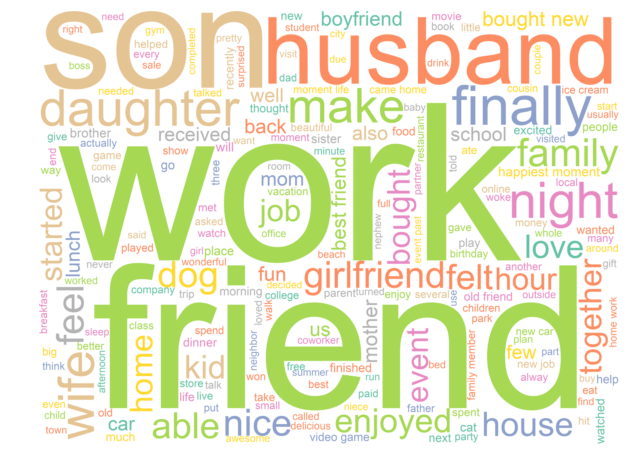

In [42]:
LIMIT_WORDS = ['happy', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going', \
               'getting', 'took', 'yesterday', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', \
               'yesterday', 'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing', \
               'toi', 'without', 'yesteri', '2s', 'toand', 'ing' ]

text = ' '.join(df_hm['cleaned_hm'].tolist())
text = text.lower()
for w in LIMIT_WORDS:
    text = text.replace(' ' + w, '')
    text = text.replace(w + ' ', '')
wordcloud = WordCloud(background_color="white", font_path='../../../Library/Fonts/Arial.ttf', \
                          height=2700, width=3600).generate(text)
plt.figure( figsize=(14,8) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")

## Seasons that make people happy

In [14]:
seasons = ['Spring', 'Summer', 'Fall', 'Autumn', 'Winter', 'spring', 'summer', 'fall', 'autumn', 'winter']

# Check each moment, and increase the count for the mentioned season
season_dic = dict((x,0) for x in seasons)
tokens_hm = df_hm['hm'].apply(lambda x: x.split())
for _, value in tokens_hm.iteritems():
    for word in value:
        if word in seasons:
            season_dic[word] += 1
            
season_dic

{'Autumn': 0,
 'Fall': 6,
 'Spring': 81,
 'Summer': 23,
 'Winter': 6,
 'autumn': 0,
 'fall': 90,
 'spring': 253,
 'summer': 438,
 'winter': 71}

Spring is the most popular season -- as expected -- followed by Summer.  

Fall and Winter have equal number of mentioning.

## Countries that make people happy

## Identify purchasing-related moments

Let's use Python to take a peek at all the happy moments related to purchasing behavior -- 
i.e., moments that contain keywords 'buy', 'bought' or 'purchase'.  

This process could help us understand the patterns of products appearing in the happy moments, and faciliate condition specification in latter steps when we use KOKO.

In [15]:
num_moments = 100
assert (num_moments < data_clean.size)
print('Happy moments involving purchasing:\n')
for i in range(0, num_moments):
    if 'buy' in data_clean.iloc[i] or \
       'bought' in data_clean.iloc[i] or \
       'purchase' in data_clean.iloc[i]:
       print("{}: {}".format(i, data_clean.iloc[i]))

NameError: name 'data_clean' is not defined

<a id='koko_syntax'></a>
# 2. Introduction to KOKO

Before using KOKO to extract products from HappyDB, I'll give a brief introduction of KOKO's query language.

**Here's am example query *Q_prod* that I'll use to extract products.**

In [14]:
with open('./products.koko', 'r') as query:
    print(query.read())

extract "Ngrams(1,1)" x from "./happydb.txt" if
		   ("bought a new" x {0.01}) or
		   ("bought a few" x {0.01}) or
		   ("bought some" x {0.01}) or
		   ("bought a" x {0.01}) or
		   (x "I bought" {0.01}) or		   
		   ("purchased a new" x {0.01}) or
		   ("purchased a few" x {0.01}) or
		   ("purchased some" x {0.01}) or
		   ("purchased a" x {0.01}) or
		   (x "I purchased" {0.01})
with threshold 0.2
excluding (str(x) matches ".*(new|NEW|few).*")
excluding (str(x) matches ".*(,|\.|;|!|\$|\(|\)|-).*")
excluding (str(x) matches ".*[0-9]+.*")
excluding (str(x) matches ".*(and|or|so|the|this|that).*")



To understand *Q_prod*, let's take a look at the syntax of KOKO.

<a id='koko_syntax'></a>
## KOKO syntax

(**extract** ⟨keyword⟩ x **from** ⟨document name⟩ **if**  
⟨condition⟩  
(**with threshold** ⟨threshold⟩)  
[**excluding** ⟨e-condition⟩]

where the conditions are defined as follows:

*⟨condition⟩ ::= ⟨condition⟩ or ⟨condition⟩ |*  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
              *(x {⟨string⟩} ⟨weight⟩) |*  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
              *(x ⟨string⟩ ⟨weight⟩) |*  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
              *(x near ⟨string⟩ ⟨weight⟩) |*  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
              *(str(x) matches⟨pattern⟩) |*  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
              *(str(x) [contains|mentions] {⟨string⟩} ⟨weight⟩) |*  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
              *(str(x) [contains|mentions] ⟨string⟩ ⟨weight⟩)*
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  
*⟨weight⟩ ::= empty | number in [0,1]*
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  
*⟨threshold⟩ ::= number in [0,1]*
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  
*⟨pattern⟩::= ⟨regular expression⟩*

Specifically, a KOKO query will extract entities *x* of type ⟨keyword⟩ from a document ⟨document name⟩, 
if the score of *x* exceeds the treshold ⟨threshold⟩.  

The score is computed as the cumulative weights of conditions that are satisfied by *x* in the dataset.

** Let's use the query *Q_prod* presented above as an example**

In *Q_prod*, the ⟨keyword⟩ is "Ngrams(1,1)", which means all the one-gram in the document.  
We can also use "Ents" for named entities, or "Nps" for noun phrases.  

There are twelve conditions in ⟨condition⟩. For example, ("bought a new" x {0.01}) means that an entity *x* with a preceding string of "bought a new" will have its score increased by 0.01 -- i.e., the weight of the condition.  

And the first "excluding" keyword specifies that the matching entities should not be any word containing "new", "NEW", or "few" -- we are more interested in "car", for instance, than "a new car" or "a few cars".  
Other "excluding" conditions have a similar role.

# 3. Entity extraction with KOKO

Now we are ready to run the query for product extraction.  

First, we need to install the KOKO package.

## Install KOKO

To install KOKO locally, simply run the following command:

    pip install pykoko

## Generate plain-text happy moments

KOKO queries take texts as input. Let's generate plain-text happy moments for query evaluation.

In [19]:
import sys

# Read the happyDB sample file
with open('./happydb.txt', 'w') as ofile:
    for i in range(0, data_clean.size-1):    
        ofile.write("\t" + str(data_clean.iloc[i]) + '\n')
        
print("Plain-text happy moments are generated!")

Plain-text happy moments are generated!


## Run KOKO

After KOKO is installed, we can run the example query *Q_prod*.  

Considering the size of the dataset, it might take several minutes to get results.

In [ ]:
import koko

koko.run('./products.koko')

Loading embedding models
Creating QueryExpander for: en
Embeddings file not found: /Users/chen/.virtualenv/python3/lib/python3.6/site-packages/koko/../embeddings/commoncrawl.840B.300d.txt
Ontology file not found: /Users/chen/.virtualenv/python3/lib/python3.6/site-packages/koko/../coffee_ontology.txt
Creating QueryExpander for: ja
Embeddings file not found: /Users/chen/.virtualenv/python3/lib/python3.6/site-packages/koko/../embeddings/japanese_noun_verb_embedding_vectors.txt
Ontology file not provided
Done loading embedding models
Parsed query: extract "./happydb.txt" Ngrams(1,1) from "x" if
	("bought a new" x { 0.01 }) or
	("bought a few" x { 0.01 }) or
	("bought some" x { 0.01 }) or
	("bought a" x { 0.01 }) or
	(x "I bought" { 0.01 }) or
	("purchased a new" x { 0.01 }) or
	("purchased a few" x { 0.01 }) or
	("purchased some" x { 0.01 }) or
	("purchased a" x { 0.01 }) or
	(x "I purchased" { 0.01 })   
with threshold 0.20
excluding
	(str(x) matches ".*(new|NEW|few).*")
	(str(x) matches 

The results contain certain noise, such as "When", "pair". But most entries are relevant.

**It seems that expensive purchase, such as cars, houses or laptops, are mentioned most in HappyDB.**  

Well, this makes sense. Expensive purchase is often for products people long for but could only afford after saving money for an extended period of time.  
No wonder such purchase makes people happy.

We can also use spaCy or Google NLP for document parsing, instead of KOKO's default parser.

**Here's an example of using spaCy as the parser**

In [17]:
import spacy

koko.run('./products.koko', doc_parser='spacy')

INFO 2017-09-22 15:15:48,160 - Loading SpaCy English models
INFO 2017-09-22 15:15:48,160 - Loading SpaCy English models
INFO 2017-09-22 15:15:48,160 - Loading SpaCy English models
INFO 2017-09-22 15:15:48,160 - Loading SpaCy English models
INFO 2017-09-22 15:15:50,853 - Done
INFO 2017-09-22 15:15:50,853 - Done
INFO 2017-09-22 15:15:50,853 - Done
INFO 2017-09-22 15:15:50,853 - Done
Parsed query: extract "/Users/chen/Research/Playground/Github_Playground/happydb/data/happyDB_clean.txt" Ngrams(1,1) from "x" if
	("bought a new" x { 0.01 }) or
	("bought a few" x { 0.01 }) or
	("bought some" x { 0.01 }) or
	("bought a" x { 0.01 }) or
	(x "I bought" { 0.01 }) or
	("purchased a new" x { 0.01 }) or
	("purchased a few" x { 0.01 }) or
	("purchased some" x { 0.01 }) or
	("purchased a" x { 0.01 }) or
	(x "I purchased" { 0.01 })   
with threshold 0.20
excluding
	(str(x) matches ".*(new|NEW|few).*")
	(str(x) matches ".*(,|\.|;|!|\$|\(|\)|-).*")
	(str(x) matches ".*[0-9]+.*")
	(str(x) matches ".*(and|

The results are slightly different. But the entities extracted are identical except "TV".

# 4. Conclusion

This is a quick and preliminary analysis of the HappyDB dataset. In the analysis:

- I tried to extract the products that tend to make people happy.

- I introduced KOKO, an entity extraction system with a declarative rule-based specification language.

- I showed how to write KOKO queries to concisely specify desirable entities, and use KOKO runtime to extract these entities.